In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M31 star clusters catalog of Johnson et al. (2015, ApJ)

# Import the libraries we'll need
from astropy.io import ascii
from astropy import table
from astropy.table import unique, Table, hstack, Column
import sys
from numpy import inf
import numpy as np
import numpy.ma as ma
import time
from matplotlib.pyplot import figure as fig
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from slugpy.cluster_slug import cluster_slug
from slugpy import * 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

In [2]:
#Imported AP fits files which include best fit of mass and age data already 

apdata = Table.read('apdata-cluster_6phot+agemass.fits')
print("Reading AP Cluster Data (Phot+Agemasss)...")
apdata_12clusters = Table.read('apdata-cluster_6phot+agemass_select.fits')
print("Reading AP 12 Cluster Data (Phot+AgeMass)...")

apdata_good_phot6filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_6filts.fits')
apdata_good_phot_no110_160=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_4filts_no110_160.fits')

LEGUS_PHAT_PadKroupa_prop=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_prop.fits')
LEGUS_PHAT_PadKroupa_phot=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_phot.fits')

dmod_M31=24.47 

Reading AP Cluster Data (Phot+Agemasss)...
Reading AP 12 Cluster Data (Phot+AgeMass)...


In [3]:
#Extract photometry from the AP PHAT catalog and pack it into arrays
cluster_id = np.array(apdata_good_phot6filts['ID'])

#F275W filter with error
apdata_good_phot6filts['MAG275'][apdata_good_phot6filts['MAG275'] == 'INDEF'] = -99
m275 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG275'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG275'][apdata_good_phot6filts['SIG275'] == 'INDEF'] = -99
m275err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG275'], 
                                   dtype='float64'), -99)

#F336W filter with error
apdata_good_phot6filts['MAG336'][apdata_good_phot6filts['MAG336'] == 'INDEF'] = -99
m336 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG336'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG336'][apdata_good_phot6filts['SIG336'] == 'INDEF'] = -99
m336err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG336'], 
                                   dtype='float64'), -99)

#F475W filter with error
apdata_good_phot6filts['MAG475'][apdata_good_phot6filts['MAG475'] == 'INDEF'] = -99
m475 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG475'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG475'][apdata_good_phot6filts['SIG475'] == 'INDEF'] = -99
m475err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG475'],
                                   dtype='float64'), -99)
#F814W filter with error
apdata_good_phot6filts['MAG814'][apdata_good_phot6filts['MAG814'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG814'], dtype='float64'), -99) - dmod_M31
apdata_good_phot6filts['SIG814'][apdata_good_phot6filts['SIG814'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG814'],
                                   dtype='float64'), -99)

#F110W filter with error
#apdata_good_phot6filts['MAG110'][apdata_good_phot6filts['MAG110'] == 'INDEF'] = -99
#m110 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG110'], dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG110'][apdata_good_phot6filts['SIG110'] == 'INDEF'] = -99
#m110err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG110'],
#                                   dtype='float64'), -99)

#F160W filter with error 
#apdata_good_phot6filts['MAG160'][apdata_good_phot6filts['MAG160'] == 'INDEF'] = -99
#m160 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG160'],dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG160'][apdata_good_phot6filts['SIG160'] == 'INDEF'] = -99
#m160err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG160'],
#                                   dtype='float64'), -99)

apdata_good_phot6filts_logm=apdata_good_phot6filts['BEST_MASS']
apdata_good_phot6filts_logt=apdata_good_phot6filts['BEST_AGE']
apdata_good_phot6filts_logx=apdata_good_phot6filts['CMD_AV_BEST']

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


In [4]:
# Mask entries with bad data in one or more filters for the actual M31 data
valid = np.logical_and(np.logical_not(m275.mask),
                       np.logical_not(m336.mask))
valid = np.logical_and(valid, np.logical_not(m475.mask))
valid = np.logical_and(valid, np.logical_not(m814.mask))
#valid = np.logical_and(valid, np.logical_not(m110.mask))
#valid = np.logical_and(valid, np.logical_not(m160.mask))

In [5]:
# Create array of photometry to pass to cluster_slug
phot=np.zeros((np.sum(616), 4)) #Creating an empty array of zeros with the shape of 2753x6 
photerr=np.zeros((np.sum(616), 4))#Creating an empty array of zeros with the shape of 2753x6 

In [6]:
#Defining the filters defined in the parameter file. Filters used for M3!
phot[:,0] = m275[valid]
phot[:,1] = m336[valid]
phot[:,2] = m475[valid]
phot[:,3] = m814[valid]
#phot[:,4] = m110[valid]
#phot[:,5] = m160[valid] 
photerr[:,0] = m275err[valid]
photerr[:,1] = m336err[valid]
photerr[:,2] = m475err[valid]
photerr[:,3] = m814err[valid]
#photerr[:,4] = m110err[valid]
#photerr[:,5] = m160err[valid] 

# Set up filter list (Commented out the original list of filters originally for chdata) for M31 AP PHAT 
filters = ['WFC3_UVIS_F275W', 'WFC3_UVIS_F336W', 'ACS_F475W', 'ACS_F814W']

In [7]:
# Define the sample density (For AP PHAT Data)
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    return sden

In [8]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                ktype='gaussian',sample_density=sample_density,
                libname='LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials')
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Computation time: 1205.062934 seconds total, 0.978135 seconds / PDF


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


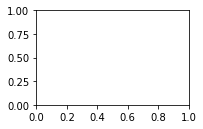

In [9]:
# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()


# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)
logx, xpdf = cs.mpdf(2, phot, photerr, ngrid=1000, filters=filters)

# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [10]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)
xmean = np.sum(logx*xpdf*(logx[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])
xpdfsum = np.cumsum(xpdf, axis=1)*(logx[1]-logx[0])
xpercentiles = np.array([
    logx[np.argmax(np.greater(xpdfsum, 0.1), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.5), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.9), axis=1)]])

In [11]:
# For each model, find the best match in the library for the 12 hand-picked clusters
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=1)
dist = dist/np.sqrt(len(filters))

In [12]:
mp25=mpercentiles[0]
mp50=mpercentiles[1]
mp75=mpercentiles[2]
tp25=tpercentiles[0]
tp50=tpercentiles[1]
tp75=tpercentiles[2]
xp25=xpercentiles[0]
xp50=xpercentiles[1]
xp75=xpercentiles[2]

In [13]:
m_matches=matches[:,:-8]
t_matches=matches[:,1:-7]
x_matches=matches[:,2:-6]

In [14]:
pmatches, dist = cs.bestmatch(phot, filters=filters, nmatch=100)

In [15]:
phot_matches=pmatches[:,-6:]+dmod_M31

In [16]:
apdata_good_phot6filts_BT=apdata_good_phot6filts['BEST_METHOD']
indBT=np.where(apdata_good_phot6filts_BT!='M')
indBTM=np.where(apdata_good_phot6filts_BT=='M')

In [17]:
apdata_good_phot6filts.remove_rows(indBT)

In [18]:
len(mpercentiles[1][indBTM[0]])

358

In [19]:
(apdata_good_phot6filts_logm[indBTM[0]])

3.4112523
3.826866
3.5705638
3.1191373
3.4402668
3.319657
3.8409822
3.5241745
3.919013
3.4958994
3.9561028


In [20]:
len(apdata_good_phot6filts['BEST_MASS'])

358

In [21]:
(apdata_good_phot6filts_logm[indBTM[0]])

3.4112523
3.826866
3.5705638
3.1191373
3.4402668
3.319657
3.8409822
3.5241745
3.919013
3.4958994
3.9561028


In [22]:
#Difference of the median of the Mass PDF & the previous mass apdata estimates for only CMD estimates in apdata
diff_PDFMedian_m_apdata=(apdata_good_phot6filts_logm[indBTM[0]])-(mpercentiles[1][indBTM[0]])

In [23]:
sorted_mPDF_apdataMedian=np.sort(diff_PDFMedian_m_apdata)
diff_PDFMedian_m_apdata_25q=np.median(sorted_mPDF_apdataMedian[0:179])
diff_PDFMedian_m_apdata_75q=np.median(sorted_mPDF_apdataMedian[180:358])


In [24]:
#Diff. of median of  Mass PDF & previous mass apdata estimates for only CMD estimates in apdata
#25 percentile, the median of the median of PDF - CMD Mass, and 75th percentile
diff_PDFMedian_m_apdata_25q, np.median(diff_PDFMedian_m_apdata),diff_PDFMedian_m_apdata_75q

(0.006796239005779192, 0.21018679991525913, 0.4249072351077463)

In [25]:
#IQR for Difference of Mass PDF Median and apdata Age
diff_PDFMedian_m_apdata_75q-diff_PDFMedian_m_apdata_25q

0.4181109961019671

In [26]:
#Standard Deviation of Mass model distributions
mass_sigma=np.std(diff_PDFMedian_m_apdata)
mass_sigma

0.43445800887208486

In [27]:
#Width of the mass distribution Median to p25
Med_p25=np.median(diff_PDFMedian_m_apdata)-diff_PDFMedian_m_apdata_25q
p75_Med=diff_PDFMedian_m_apdata_75q-np.median(diff_PDFMedian_m_apdata)
Med_p25, p75_Med

(0.20339056090947993, 0.21472043519248718)

In [28]:
apdata_good_phot6filts['BEST_AGE']

8.4
8.5
8.4
7.2
8.5
7.5
8.1
8.2
8.2
8.2
8.4


In [29]:
apdata_good_phot6filts_logt[indBTM[0]]

8.4
8.5
8.4
7.2
8.5
7.5
8.1
8.2
8.2
8.2
8.4


In [30]:
#Difference of the median of the Age PDF & the previous age apdata estimates for only CMD estimates in apdata
diff_PDFMedian_t_apdata=(apdata_good_phot6filts_logt[indBTM[0]])-(tpercentiles[1][indBTM[0]])

In [31]:
#Finding the 25th, 75th standard deviation from diff of age PDF median minus apdata age. 
sorted_tPDF_apdataMedian=np.sort(diff_PDFMedian_t_apdata)
diff_PDFMedian_t_apdata_25q=np.median(sorted_tPDF_apdataMedian[0:179])
diff_PDFMedian_t_apdata_75q=np.median(sorted_tPDF_apdataMedian[180:358])

In [32]:
#Diff. of median of  Age PDF & previous Age apdata estimates for only CMD estimates in apdata
#25 percentile, the median of the median of PDF - CMD Age, and 75th percentile
diff_PDFMedian_t_apdata_25q, np.median(diff_PDFMedian_t_apdata), diff_PDFMedian_t_apdata_75q

(-0.09370042341138074, 0.24724398779235468, 0.5149609458955426)

In [33]:
#IQR for Difference of Age PDF Median and apdata Age
AgeIQR=diff_PDFMedian_t_apdata_75q-diff_PDFMedian_t_apdata_25q
AgeIQR

0.6086613693069234

In [34]:
#standard deviation from diff of age PDF median minus apdata age
age_sigma=np.std(diff_PDFMedian_t_apdata)
age_sigma

0.6043932469502526

In [35]:
(apdata_good_phot6filts['CMD_AV_BEST'])

0.45
0.5
0.75
0.7
0.5
0.5
1.75
0.3
1.1
0.35
0.6


In [36]:
(apdata_good_phot6filts_logx[indBTM[0]])

0.45
0.5
0.75
0.7
0.5
0.5
1.75
0.3
1.1
0.35
0.6


In [37]:
#Difference of the median of the A_v PDF & the previous A_v apdata estimates for only CMD estimates in apdata
diff_PDFMedian_x_apdata=(apdata_good_phot6filts_logx[indBTM[0]])-(xpercentiles[1][indBTM[0]])

In [38]:
#Finding the 25th, 75th standard deviation from diff of A_v PDF median minus apdata A_v. 
sorted_xPDF_apdataMedian=np.sort(diff_PDFMedian_x_apdata)
diff_PDFMedian_x_apdata_25q=np.median(sorted_xPDF_apdataMedian[0:179])
diff_PDFMedian_x_apdata_75q=np.median(sorted_xPDF_apdataMedian[180:358])

In [39]:
#Diff. of median of  A_v PDF & previous A_v apdata estimates for only CMD estimates in apdata
#25 percentile, the median of the median of PDF - CMD A_v, and 75th percentile
diff_PDFMedian_x_apdata_25q, np.median(diff_PDFMedian_x_apdata), diff_PDFMedian_x_apdata_75q

(-0.35583440800717603, -0.05784661949817854, 0.34905225934640216)

In [40]:
#IQR for Difference of A_v PDF Median and apdata A_v
A_vIQR=diff_PDFMedian_x_apdata_75q-diff_PDFMedian_x_apdata_25q
A_vIQR

0.7048866673535782

In [41]:
#standard deviation from diff of age PDF median minus apdata age
A_v_sigma=np.std(diff_PDFMedian_x_apdata)
A_v_sigma

0.6041388088332948

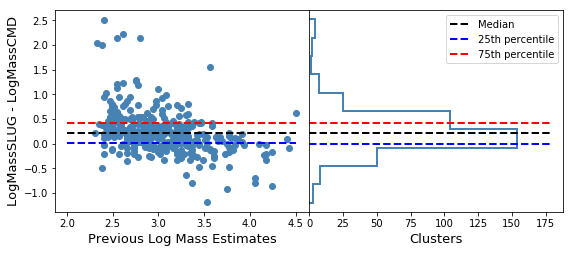

In [42]:
#X=np.arange(-1.5,3,0.5)
#plt.plot(X,X,'k--')
#plt.scatter(mpercentiles[1][indBTM[0]],diff_PDFMedian_m_apdata, color='dodgerblue')
#plt.ylim(1.9,5)
#plt.xlim(1.8,6.5)
#plt.ylabel('MassPDF_Median-Previous Est.', fontsize=13)
#plt.xlabel('Previous Log Mass Estimates', fontsize=13);


x=np.arange(2,5,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(mpercentiles[1][indBTM[0]],diff_PDFMedian_m_apdata, color='steelblue')
plt.plot(x,np.median(diff_PDFMedian_m_apdata)*np.ones(6),'k--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(x,diff_PDFMedian_m_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('LogMassSLUG - LogMassCMD', fontsize=13)
plt.xlabel('Previous Log Mass Estimates', fontsize=13);


plt.subplot(1,2,2)
a=np.arange(0,180,1)
plt.hist(diff_PDFMedian_m_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(a,np.median(diff_PDFMedian_m_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(a,diff_PDFMedian_m_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(a,diff_PDFMedian_m_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDMassEst_vs_CMDMassEst_4filts.pdf')

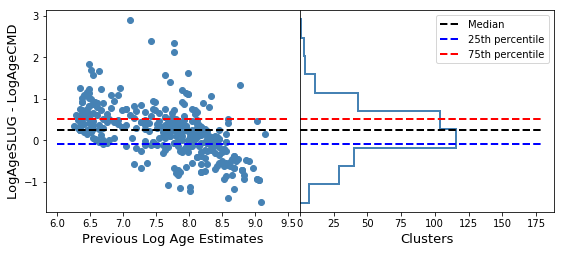

In [43]:
#plt.subplot(2,2,3)
Y=np.arange(6,10,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(tpercentiles[1][indBTM[0]],diff_PDFMedian_t_apdata, color='steelblue')
plt.plot(Y,np.median(diff_PDFMedian_t_apdata)*np.ones(8),'k--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_25q*np.ones(8),'b--',lw=2)
plt.plot(Y,diff_PDFMedian_t_apdata_75q*np.ones(8),'r--',lw=2)
plt.ylabel('LogAgeSLUG - LogAgeCMD', fontsize=13)
plt.xlabel('Previous Log Age Estimates', fontsize=13);

plt.subplot(1,2,2)
b=np.arange(0,180,1)
plt.hist(diff_PDFMedian_t_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(b,np.median(diff_PDFMedian_t_apdata)*np.ones(180),'k--',lw=2,label='Median')
plt.plot(b,diff_PDFMedian_t_apdata_25q*np.ones(180),'b--',lw=2,label='25th percentile')
plt.plot(b,diff_PDFMedian_t_apdata_75q*np.ones(180),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()
plt.xlabel('Clusters', fontsize=13);

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDAgeEst_vs_CMDAgeEst_4filts.pdf')


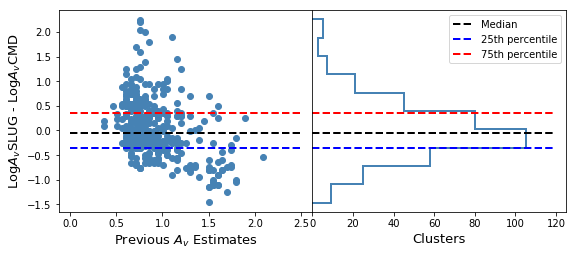

In [44]:
#plt.subplot(2,2,3)
Z=np.arange(0,3,0.5)
ax=plt.subplot()
plt.subplot(1,2,1)
plt.scatter(xpercentiles[1][indBTM[0]],diff_PDFMedian_x_apdata, color='steelblue')
plt.plot(Z,np.median(diff_PDFMedian_x_apdata)*np.ones(6),'k--',lw=2)
plt.plot(Z,diff_PDFMedian_x_apdata_25q*np.ones(6),'b--',lw=2)
plt.plot(Z,diff_PDFMedian_x_apdata_75q*np.ones(6),'r--',lw=2)
plt.ylabel('Log$A_v$SLUG - Log$A_v$CMD', fontsize=13)
plt.xlabel('Previous $A_v$ Estimates', fontsize=13);

plt.subplot(1,2,2)
c=np.arange(0,120,1)
plt.hist(diff_PDFMedian_x_apdata, orientation='horizontal',histtype='step',lw=2,color='steelblue')
plt.plot(c,np.median(diff_PDFMedian_x_apdata)*np.ones(120),'k--',lw=2,label='Median')
plt.plot(c,diff_PDFMedian_x_apdata_25q*np.ones(120),'b--',lw=2,label='25th percentile')
plt.plot(c,diff_PDFMedian_x_apdata_75q*np.ones(120),'r--',lw=2,label='75th percentile')
plt.xlabel('Clusters',fontsize=13)
plt.yticks([])
plt.legend()
plt.xlabel('Clusters', fontsize=13);

plt.subplots_adjust(hspace=0.4, wspace=0, bottom=0.5, top=1.2, right=1.3)
plt.savefig('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Model_Comparison_Files/SlugPDF-CMDA_vEst_vs_CMDA_vEst_4filts.pdf')


In [45]:
sorted_ageMedian=np.sort(tpercentiles[1][indBTM[0]])
MedAgequartile_75th=np.median(sorted_ageMedian[180:358])
MedAgequartile_25th=np.median(sorted_ageMedian[0:179])
MedAgequartile_25th, MedAgequartile_75th

(6.9763780662672605, 8.173228217809513)

In [46]:
sorted_massMedian=np.sort(mpercentiles[1][indBTM[0]])
MedMassquartile_75th=np.median(sorted_massMedian[180:358])
MedMassquartile_25th=np.median(sorted_massMedian[0:179])
MedMassquartile_25th, MedMassquartile_75th

(2.6613945350775348, 3.287348814634943)

In [47]:
m1_matches=(matches[:,:1])
t1_matches=matches[:,1:2]

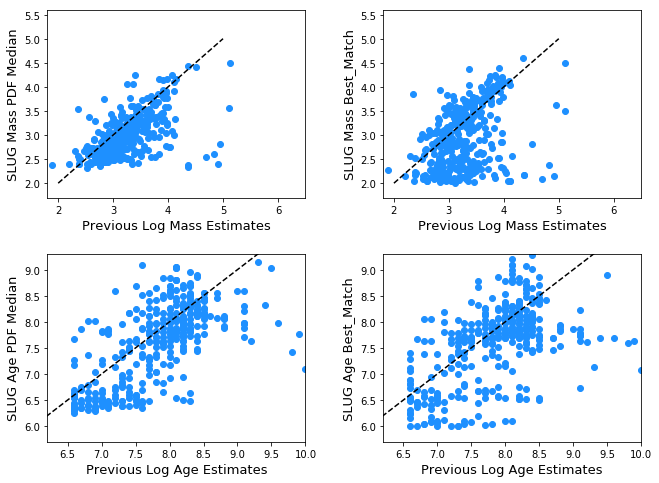

In [48]:
#Here we are comparing previous estimates of M31 Cluster Ages, Masses, and Extinction to the generated SLUG Best 
#Match models, and the PDFs 25th, median(50th), and 75th percentiles. 

plt.subplot(2,2,1)
X=np.arange(2,5.5,0.5)
plt.plot(X,X,'k--')
plt.scatter(apdata_good_phot6filts['BEST_MASS'],mpercentiles[1][indBTM[0]], color='dodgerblue')
plt.ylim(1.7,5.6)
plt.xlim(1.8,6.5)
plt.ylabel('SLUG Mass PDF Median', fontsize=13)
plt.xlabel('Previous Log Mass Estimates', fontsize=13);


plt.subplot(2,2,2)
X=np.arange(2,5.5,0.5)
plt.plot(X,X,'k--')
plt.scatter(apdata_good_phot6filts['BEST_MASS'], m1_matches[indBTM[0]],color='dodgerblue')
plt.ylim(1.7,5.6)
plt.xlim(1.8,6.5)
plt.ylabel('SLUG Mass Best_Match', fontsize=13)
plt.xlabel('Previous Log Mass Estimates', fontsize=13);


plt.subplot(2,2,3)
Y=np.arange(6,10,0.5)
plt.plot(Y,Y,'k--')
plt.scatter(apdata_good_phot6filts['BEST_AGE'],tpercentiles[1][indBTM[0]],color='dodgerblue')
plt.ylim(5.7,9.3)
plt.xlim(6.2,10)
plt.ylabel('SLUG Age PDF Median', fontsize=13)
plt.xlabel('Previous Log Age Estimates', fontsize=13);


plt.subplot(2,2,4)
Y=np.arange(6,10,0.5)
plt.plot(Y,Y,'k--')
plt.scatter(apdata_good_phot6filts['BEST_AGE'], t1_matches[indBTM[0]],color='dodgerblue')
plt.ylim(5.7,9.3)
plt.xlim(6.2,10)
plt.ylabel('SLUG Age Best_Match', fontsize=13)
plt.xlabel('Previous Log Age Estimates', fontsize=13);


plt.savefig('SLUG PDF Median & SLUG Best Match vs Previous Log Mass & Age Estimates.png')

plt.subplots_adjust(hspace=0.3, wspace=0.3, bottom=0.5, top=2, right=1.5)

In [17]:
y=np.linspace(0,10000000,10000000)

In [18]:
len(y)

10000000

In [19]:
type(LEGUS_PHAT_PadKroupa_prop['A_V'])

astropy.table.column.Column

In [14]:
sorted_SLUG_Av=np.array(np.sort(LEGUS_PHAT_PadKroupa_prop['A_V']))
type(sorted_SLUG_Av)

numpy.ndarray

In [39]:
stats.mode(list(LEGUS_PHAT_PadKroupa_prop['A_V']))

ModeResult(mode=array([0.0167577]), count=array([1]))

In [37]:
len(sorted_SLUG_Av)

10000000

In [43]:
split_sorted_SLUG_Av=np.array_split(sorted_SLUG_Av, 1000)
len(split_sorted_SLUG_Av[2])

10000

In [ ]:
for i in range(len(split_sorted_SLUG_Av)):
    plt.bar(split_sorted_SLUG_Av[i],10000)

In [40]:
len(np.where(LEGUS_PHAT_PadKroupa_prop['A_V']<=0.5))

1

Text(0.5, 0, 'A_v')

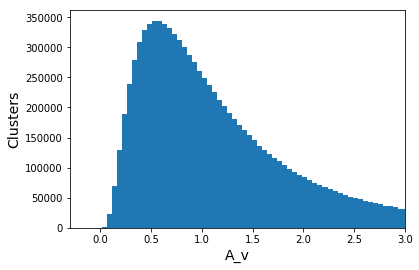

In [30]:
plt.hist(sorted_SLUG_Av,bins=1000) 
plt.xlim(-0.3,3)
plt.ylabel('Clusters',fontsize=14)
plt.xlabel('A_v',fontsize=14)

Text(0.5, 0, 'A_v')

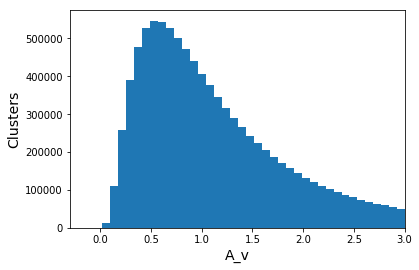

In [3]:
plt.hist(LEGUS_PHAT_PadKroupa_prop['A_V'],bins=800) 
plt.xlim(-0.3,3)
plt.ylabel('Clusters',fontsize=14)
plt.xlabel('A_v',fontsize=14)

Text(0.5, 0, 'A_v')

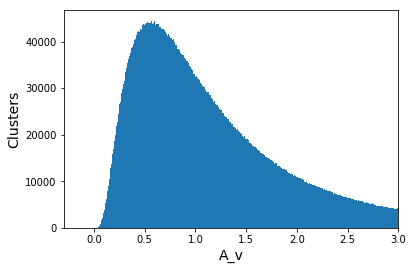

In [15]:
plt.hist(LEGUS_PHAT_PadKroupa_prop['A_V'],bins=7800)
plt.xlim(-0.3,3,0.2)
plt.ylabel('Clusters',fontsize=14)
plt.xlabel('A_v',fontsize=14)

In [14]:
SLUG_Av=(list(LEGUS_PHAT_PadKroupa_prop['A_V']))
type(SLUG_Av)

list

In [82]:
A,B

(0.01675770387329732, 49.39242355901861)

In [63]:
A=min(LEGUS_PHAT_PadKroupa_prop['A_V'])
B=max(LEGUS_PHAT_PadKroupa_prop['A_V'])
a=0
b=1

In [64]:
#Normalizing extincition values from SLUG models
norm_SLUG_Av=[]
for i in range(10000000):
    Av=a+((SLUG_Av[i]-A)*(b-a)/(B-A))
    norm_SLUG_Av.append(Av)

In [65]:
norm_SLUG_Av

[0.018552728558602148,
 0.016706182759473907,
 0.02293198886795852,
 0.10036574615034666,
 0.02215472531445598,
 0.009163855566390707,
 0.02567218340498082,
 0.01231481802831885,
 0.02736436412256542,
 0.022164918168932075,
 0.011878615087333516,
 0.006487189587913463,
 0.011301892648596237,
 0.019100098864337483,
 0.01788976106751009,
 0.014193799556194108,
 0.017488394431355324,
 0.02107408529169828,
 0.005141468027800531,
 0.017792189045939363,
 0.0058763565296855984,
 0.02377596557199073,
 0.010033741229051107,
 0.004666376636003693,
 0.019141377942921332,
 0.019634231517379235,
 0.05223909679338729,
 0.05854070534511131,
 0.013574376501376596,
 0.026235411021441918,
 0.0687557344799284,
 0.05064832136231142,
 0.033794373826322784,
 0.02642174591211713,
 0.01763421331691591,
 0.029042889467816153,
 0.038017754315400325,
 0.03455150673598575,
 0.005233399122668108,
 0.021053967658670555,
 0.03523075700847737,
 0.025908122454495724,
 0.045591674846658596,
 0.010348962533114178,
 0.00

In [67]:
apdata_Av=list(apdata['CMD_AV_BEST'])
len(apdata_Av)

2753

In [66]:
C=min(apdata['CMD_AV_BEST'])
D=max(apdata['CMD_AV_BEST'])

In [68]:
#Normalizing extincition values from APdata Estimates
norm_apdata_Av=[]
for i in range(len(apdata_Av)):
    A_v=a+((apdata_Av[i]-C)*(b-a)/(D-C))
    norm_apdata_Av.append(A_v)

Text(0.5, 0, 'Normalized Extinction')

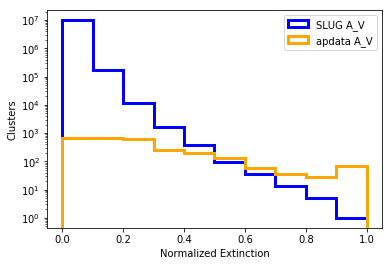

In [77]:
plt.hist(norm_SLUG_Av,histtype='step',color='blue',lw=3,label='SLUG A_V')
plt.yscale('log')
plt.hist(norm_apdata_Av,histtype='step',color='orange',lw=3,label='apdata A_V')
plt.legend()
plt.ylabel('Clusters')
plt.xlabel('Normalized Extinction')

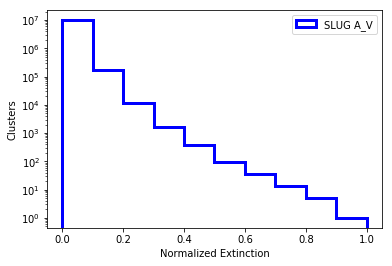

In [81]:
plt.hist(norm_SLUG_Av,histtype='step',color='blue',lw=3,label='SLUG A_V',)
plt.yscale('log')
plt.ylabel('Clusters')
plt.xlabel('Normalized Extinction')
plt.legend()

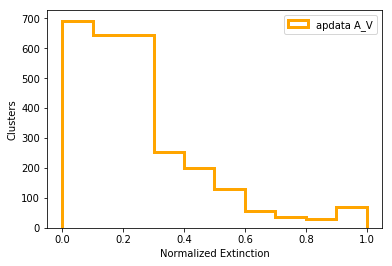

In [80]:
plt.hist(norm_apdata_Av,histtype='step',color='orange',lw=3,label='apdata A_V')
plt.ylabel('Clusters')
plt.xlabel('Normalized Extinction')
plt.legend()